## Imports

In [15]:
import pathlib
import os
import os.path as osp
import sys
import argparse
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero

from utils.grid_search import grid_search
from utils.visualize import plot_loss, plot_train, plot_val, plot_test

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read the dataset

In [3]:
path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLens')
dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

#### Preprocess the dataset

In [4]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

#### Define the grid search space

In [5]:
layer_names = ["SAGE"]
encoder_min_num_layers=5
encoder_max_num_layers=7
decoder_min_num_layers=5
decoder_max_num_layers=7
epochs=30
logging_step=10

In [6]:
losses = grid_search(
    layer_names=layer_names,
    encoder_min_num_layers=encoder_min_num_layers,
    encoder_max_num_layers=encoder_max_num_layers,
    decoder_min_num_layers=decoder_min_num_layers,
    decoder_max_num_layers=decoder_max_num_layers,
    epochs=epochs,
    data=data,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    device=device,
    logging_step=logging_step,
)

--->> ('SAGE', 5, True, 5)


c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\environ\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 010, Loss: 11.8337, Train: 2.7823, Val: 2.7889, Test: 2.7794
Epoch: 020, Loss: 6.5567, Train: 1.5223, Val: 1.5117, Test: 1.5304
Epoch: 030, Loss: 6.5625, Train: 1.1225, Val: 1.1333, Test: 1.1319
--->> ('SAGE', 5, True, 6)
Epoch: 010, Loss: 15.3181, Train: 3.2337, Val: 3.2311, Test: 3.2221
Epoch: 020, Loss: 16.1590, Train: 3.2015, Val: 3.1985, Test: 3.1893
Epoch: 030, Loss: 13.2967, Train: 2.8502, Val: 2.8470, Test: 2.8378
--->> ('SAGE', 5, True, 7)
Epoch: 010, Loss: 6.8226, Train: 1.7747, Val: 1.8234, Test: 1.7872
Epoch: 020, Loss: 6.1663, Train: 1.5697, Val: 1.6160, Test: 1.5915
Epoch: 030, Loss: 5.6400, Train: 1.3714, Val: 1.3956, Test: 1.3772
--->> ('SAGE', 5, False, 5)
Epoch: 010, Loss: 11.1241, Train: 2.6299, Val: 2.6438, Test: 2.6209
Epoch: 020, Loss: 6.1514, Train: 1.5722, Val: 1.5912, Test: 1.5680
Epoch: 030, Loss: 6.5238, Train: 1.1714, Val: 1.1776, Test: 1.1647
--->> ('SAGE', 5, False, 6)
Epoch: 010, Loss: 7.4945, Train: 2.5799, Val: 2.5859, Test: 2.5691
Epoch: 020, Lo

#### Visualize

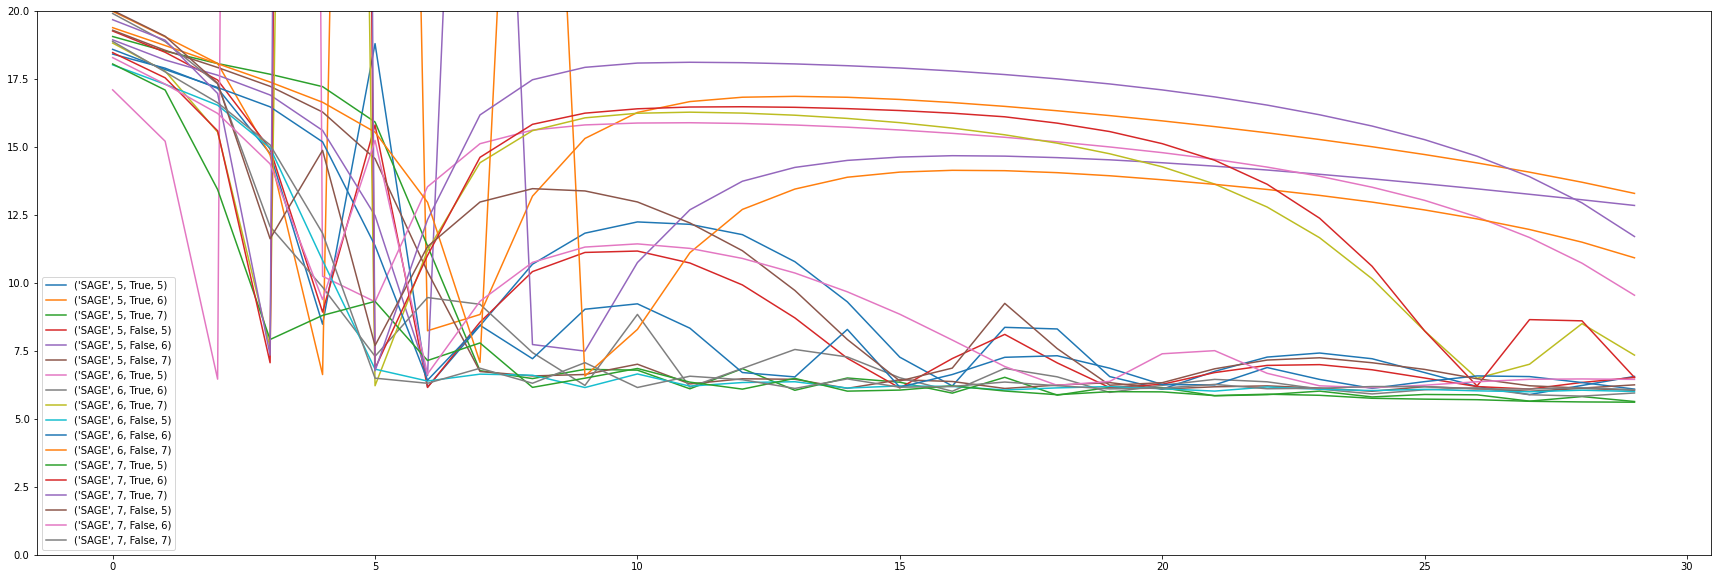

In [21]:
plot_loss(losses, ylim=20)